Experiment 1 with resnet18 transfer learning
============================================

In [153]:
from __future__ import print_function

import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
import csv
import gc
import torchnet as tnt
from utils import *
from classes import *
from tqdm import tqdm_notebook # for-loop progress bar in notebook

# plt setup and the gpu setup
plt.ion()
use_gpu = torch.cuda.is_available()


In [107]:
# ========================================
# Step 1. define data transform
#
# Including different forms of data augmentation
# One will include nearly all types (excluding random crops, etc. that may remove handwriting.)
# The other will include a selected set of augmentations
# Keeping 'train', 'val', and 'test' transforms just in case we want to include different functionalities
# ========================================

print("Set up data transforms.")

selected_transforms = {
    'train': transforms.Compose([
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(45),
        
        transforms.ColorJitter(brightness=0, contrast=0, saturation=0, hue=0.5),
        transforms.RandomGrayscale(p=0.1),
        
        transforms.Grayscale(), # not sure why the current input is not grayscale, do grayscale conversion
        transforms.Resize((28,28)),
        transforms.ToTensor(),
    ]),
    # should not do random transformation in val or test set
    'val': transforms.Compose([
        transforms.Grayscale(),
        transforms.Resize((28,28)),
        transforms.ToTensor(),
    ]),
    'test': transforms.Compose([
        transforms.Grayscale(),
        transforms.Resize((28,28)),
        transforms.ToTensor(),
    ]),
}
data_transforms = selected_transforms


Set up data transforms.


In [143]:
# ========================================
# Step 2. define and load data
#
# TODO: Suggest not using data loader to load the images. Because it is slow. Every epochs, you load the 
# image data again to the RAM and then from RAM to GPU RAM. That takes a lot of time. Since the images are 
# <1GB, you can preload the images into RAM first, that will make you training way faster. 

# Note: you only has about 200MB of images, it's small. It should not take much time to load!
# ========================================
print("Create dataset and dataloader")

# hyperparameter
batch_size = 50 # larger batch size is better so you can load more data into gpu and train faster

# data location
book_data_dir = "/home/kcho/clab_data/"
set_types = ['train', 'val', 'test']

# test books are currently arbitrarily set
test_books = set(["Albin", "Dryden"])

# Get the list of all books in the data set
books_in_data = set([b for b in os.listdir(book_data_dir)
                 if os.path.isdir(os.path.join(book_data_dir, b))])

# Create a dict of datasets for each book
book_data_sets = {b : {t : datasets.ImageFolder(os.path.join(book_data_dir, b), 
                                                transform = data_transforms[t])#, transform=test_transform)
                      for t in set_types}
                 for b in books_in_data}

# create a dict of dataloaders, book_data_loaders['Albin']['train']
book_data_loaders = {b : {t : torch.utils.data.DataLoader(book_data_sets[b][t],
                                                          batch_size=batch_size,
                                                          shuffle=True, # make sure you shuffle the data
                                                          num_workers=4)
                          for t in set_types}
                     for b in books_in_data}



Create dataset and dataloader


(1, 28, 28)
(28, 28)


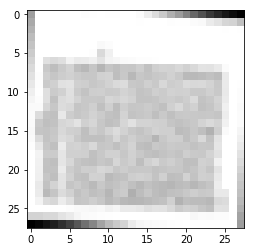

In [144]:
# ========================================
# Check your data to make sure it is correct
# ========================================

for data in book_data_loaders['Defoe']['train']:
    # get the inputs
    inputs, labels = data

    # plot to verify the input is correct
    input1 = inputs[0].numpy()
    print(input1.shape)
    input1 = np.swapaxes(input1,0,2).squeeze()
    print(input1.shape)
    plt.imshow(input1,cmap='gray')
    
    break

In [145]:
# ========================================
# Step 3. define model structure
#
# TODO: Stick with MNIST for now because it is smaller network and faster to train. Note that you lose
# a lot of inofmration when yo udownsample the image to 28x28. THat's okay, you optimize other parts first, e.g.,
# data loading before you optimize your model.
# ========================================
from lib.playground.utee import selector

def create_model_architecture(model_type='mnist'):
    """
    params model_type: the type of model, for now, support mnist and resnet18    
    """
    if model_type == 'mnist':
        print('using pretrained mnist model')
        model_annotation, ds_fetcher, is_imagenet = selector.select('mnist')
        # remove last layer
        removed = list(model_annotation.model.children())[:-1]
        model_annotation.model=torch.nn.Sequential(*removed)
        # add the new fc layer
        model_annotation.model.fc = torch.nn.Linear(256,2).cuda()

    elif model_type == 'resnet18':    
        print("Transferring resnet18 and retraining with annotations dataset.")    
        model_annotation = models.resnet18(pretrained=True)
        num_params = sum(1 for i in model_annotation.parameters())

        # There are 10 layers (model_ft.children()) in resnet18
        # Freezing the first half of resnet18, freezing all params for layers 1-5
        max_layer = 5
        curr_layer = 1
        last_layer = None
        for child in model_annotation.children():
            if curr_layer <= max_layer:
                for param in child.parameters():
                    param.requires_grad = False
                last_layer = child
                curr_layer = curr_layer + 1
            else:
                break

        # Replace the final fully connected layer to perform binary classification
        num_ftrs = model_annotation.fc.in_features
        model_annotation.fc = nn.Linear(num_ftrs, 2)
        

    # return
    if use_gpu:
        return model_annotation.cuda()
    else:
        return model_annotation.cpu()


In [172]:
# ========================================
# Step 4. define the training process.
#
# TODO: The basic process of train and validation is defined. Please implement the overall average validation 
# confusion matrix, meaning for each validation (after running all epochs), get the confusion matrix for that book,
# repeat this for the rest of 10 books. THen get the overall performance. Also, implement the early-stop as you
# originally has in your code. :) I removed them here for clarity. You can add them back. 
# ========================================

def train(model, criterion, optimizer, data_loaders, num_epochs=25, early_stopping = None):

    # stop the training, validation, and test loop
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)
        
        # looping parameters
        running_loss = 0.0
        confusion_matrix = tnt.meter.ConfusionMeter(2)
        
        # loop through train and val phase in each epoch
        for phase in ['train', 'val']:
            # check train or val
            if phase == 'train':                
                model.train(True)  # Set model to training mode
            else:
                model.train(False)  # Set model to evaluate mode

            # Iterate over each book
            running_loss = 0.0
            confusion_matrix = tnt.meter.ConfusionMeter(2)
            for book in tqdm_notebook(data_loaders[phase]):
                for data in data_loaders[phase][book]:
                    # get the inputs;  wrap them in Variable and make them into gpu or not
                    inputs, labels = data # input size: [5, 1, 28, 28] ; keep the dummy color channel:1
                    if use_gpu:
                        inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())
                    else:
                        inputs, labels = Variable(inputs), Variable(labels)
                    
                    # zero the parameter gradients
                    optimizer.zero_grad()

                    # forward
                    outputs = model(inputs)
                    _, preds = torch.max(outputs.data, 1)
                    loss = criterion(outputs, labels)
                    
                    # back
                    if phase == 'train': 
                        loss.backward()
                        optimizer.step()

                    # Add to confusion matrix
                    confusion_matrix.add(outputs.data, labels.data)

                    # statistics
                    running_loss += loss.data[0] * inputs.size(0) 
            
            # report evaluation
            print('Phase:%s' %phase)
            print('Confusion matrix:\n', confusion_matrix.conf)
            print('validation loss', running_loss)
        
    return model

In [173]:
# ========================================
# Step 5. execute the train process
# ========================================

# get the model
model = create_model_architecture()

# train parameters
num_training_epochs = 50
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
earlyStoppingCriteria = EarlyStopping(min_delta = 1e-4, patience=5)

# dataloader parameters
cross_val_loaders = {}

# leave-one-book-out cross validation
for val_book in books_in_data:
    
    # define the train and validation loaders
    train_books = books_in_data - set([val_book])    
    cross_val_loaders["train"] = {b : book_data_loaders[b]["train"] for b in train_books}
    cross_val_loaders["val"] = {b : book_data_loaders[b]["val"] for b in [val_book]}

    # train
    trained_model_weights, epoch_scores = train(model,
                                                criterion,
                                                optimizer,
                                                cross_val_loaders,
                                                num_epochs=num_training_epochs,
                                                early_stopping = earlyStoppingCriteria)

print("training complete")

using pretrained mnist model
Building and initializing mnist parameters
Epoch 0/49
----------


HBox(children=(IntProgress(value=0, max=9), HTML(value=u'')))

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:58: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number



Phase:train
Confusion matrix:
 [[ 116  502]
 [ 250 1776]]
validation loss tensor(1520.6495, device='cuda:0')


HBox(children=(IntProgress(value=0, max=1), HTML(value=u'')))


Phase:val
Confusion matrix:
 [[  0 143]
 [  0  31]]
validation loss tensor(354.2864, device='cuda:0')
Epoch 1/49
----------


HBox(children=(IntProgress(value=0, max=9), HTML(value=u'')))


Phase:train
Confusion matrix:
 [[   1  617]
 [   7 2019]]
validation loss tensor(1591.5961, device='cuda:0')


HBox(children=(IntProgress(value=0, max=1), HTML(value=u'')))


Phase:val
Confusion matrix:
 [[  0 143]
 [  0  31]]
validation loss tensor(228.1974, device='cuda:0')
Epoch 2/49
----------


HBox(children=(IntProgress(value=0, max=9), HTML(value=u'')))


Phase:train
Confusion matrix:
 [[   0  618]
 [   0 2026]]
validation loss tensor(1601.9260, device='cuda:0')


HBox(children=(IntProgress(value=0, max=1), HTML(value=u'')))


Phase:val
Confusion matrix:
 [[  0 143]
 [  0  31]]
validation loss tensor(326.5123, device='cuda:0')
Epoch 3/49
----------


HBox(children=(IntProgress(value=0, max=9), HTML(value=u'')))

Process Process-1173:
Process Process-1170:
Process Process-1172:
Traceback (most recent call last):
Traceback (most recent call last):
Process Process-1171:
  File "/usr/lib/python2.7/multiprocessing/process.py", line 267, in _bootstrap
Traceback (most recent call last):
    self.run()
Traceback (most recent call last):
  File "/usr/lib/python2.7/multiprocessing/process.py", line 114, in run
  File "/usr/lib/python2.7/multiprocessing/process.py", line 267, in _bootstrap
    self._target(*self._args, **self._kwargs)
    self.run()
  File "/usr/lib/python2.7/multiprocessing/process.py", line 114, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python2.7/multiprocessing/process.py", line 267, in _bootstrap
  File "/usr/lib/python2.7/multiprocessing/process.py", line 267, in _bootstrap
  File "/usr/lib/python2.7/multiprocessing/process.py", line 114, in run
    self.run()
    self.run()
    self._target(*self._args, **self._kwargs)
  File "/usr/local/lib/python2.7/di

KeyboardInterrupt: 

    return recv()
  File "/usr/lib/python2.7/multiprocessing/queues.py", line 376, in get
  File "/usr/local/lib/python2.7/dist-packages/torchvision/transforms/functional.py", line 595, in rotate
KeyboardInterrupt
    buf = self.recv_bytes()
    return img.rotate(angle, resample, expand, center)
  File "/usr/local/lib/python2.7/dist-packages/torch/multiprocessing/queue.py", line 21, in recv
    return F.resize(img, self.size, self.interpolation)
  File "/usr/local/lib/python2.7/dist-packages/torchvision/transforms/functional.py", line 206, in resize
    return img.resize(size[::-1], interpolation)
  File "/usr/local/lib/python2.7/dist-packages/PIL/Image.py", line 1749, in resize
    return recv()
    return self._new(self.im.resize(size, resample, box))
KeyboardInterrupt
  File "/usr/local/lib/python2.7/dist-packages/torch/multiprocessing/queue.py", line 21, in recv
    buf = self.recv_bytes()
KeyboardInterrupt
  File "/usr/local/lib/python2.7/dist-packages/PIL/Image.py", line 1854, in